## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [ ]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)

In [ ]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [ ]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [ ]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
os.mkdir("data")
os.mkdir("data/TP2_images")
!cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2022/TP2/TP2_images.zip" && unzip TP2_images.zip
dir_path = "data/" 
dataset = preprocess_image(dir_path)

--2022-02-13 15:54:00--  https://www.lri.fr/~gcharpia/deeppractice/2022/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477062 (1.4M) [application/zip]
Saving to: ‘TP2_images.zip’

TP2_images.zip      100%[===================>]   1.41M  1.71MB/s    in 0.8s    

2022-02-13 15:54:02 (1.71 MB/s) - ‘TP2_images.zip’ saved [1477062/1477062]

Archive:  TP2_images.zip
   creating: .ipynb_checkpoints/
  inflating: 155881293_721e90b57d.jpg  
  inflating: 158850087_3251644046.jpg  
  inflating: 1624593475_146bf1f7ff.jpg  
  inflating: 181748579_01a4611736.jpg  
  inflating: 2068921624_ef0986de13.jpg  
  inflating: 2637374064_fab14ec0b8.jpg  
  inflating: 2749465889_8e62023674.jpg  
  inflating: 2936812850_23bf0d1cfd.jpg  
  inflating: 3532471222_a6d7e3780e.jpg  
  inflating: 3633913271_ee789a3bc4.jpg  
  inflating: 3633949157_f577605ea9.jpg  
  infla

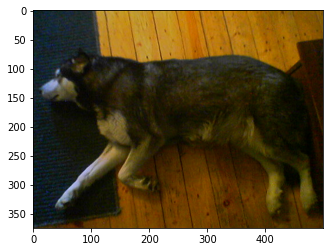

In [ ]:
# show the orignal image
index = 3
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [ ]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [174 264 235] ['Norwegian elkhound, elkhound', 'Cardigan, Cardigan Welsh corgi', 'German shepherd, German shepherd dog, German police dog, alsatian']
Raw class scores: [12.653305 11.875392 11.673957]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

![Grad-CAM](https://da2so.github.io/assets/post_img/2020-08-10-GradCAM/2.png)

## Grad_CAM implementation:

* As stated in the hint, we use Hooks to attach a hook to intermediate values to get the gradients from the model before they are discarded.
* Hooks are activated after the last convolutionnal layer, Grad Cam is defined in the paper [here](https://arxiv.org/pdf/1610.02391.pdf) as follows: "Grad-CAM uses the gradient information flowing into the **last convolutional layer** of the CNN to assign importance
values to each neuron for a particular decision of interest."




To compute $L^{c}_{grad-cam}$, the class activation map related to $c$, we first have to compute the gradient of the raw prediction $Y^{c}$ with respect to the activations with respect to the activations of each feature map $k$. 

The importance of the feature $k$ for class $c$ is defined as:

$$
\alpha_{k}^{c}=\frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^{c}}{\partial A_{i j}^{k}}
$$

Where $Z$ denotes the number of pixels of the last convolutional feature map. 
This is computed by retrieving the activation maps $A^k$ in the last convolutional layer (`layer4[3].conv2` according to the architecture implementation displayed above), and averaging the values per map.

Then, the importance of a pixel is defined as:

$$
\beta_{ij}=\sum_{k}{}\alpha_{k}^{c}A_{i j}^{k}
$$
And the resulting heatmap is:

$$
[L^{c}_{grad-cam}]_{ij}=ReLu(\beta_{ij})
$$


The activation maps are retieved through the forward hook, and the gradients retrieved through the backward hook.


In [ ]:
class resnet34_gradcam():
  """
  Gradcam class adapated to ResNet34 model.
  """
  def __init__(self):
    
    self.model =  models.resnet34(pretrained=True)
    self.model.eval()
    
    # Weights and activation storing variables
    self.alphas = None
    self.activation_map = None

    # Register hooks
    self.model.layer4[2].conv2.register_forward_hook(self.get_forward_hook())
    self.model.layer4[2].conv2.register_full_backward_hook(self.get_backward_hook())

    self.resize_crop = transforms.Compose([
          transforms.Resize(256), 
          transforms.CenterCrop(224), # resize the image to 224x224
          transforms.ToTensor() # convert numpy.array to tensor
          ])

  def get_forward_hook(self):
    """ Returns forward hook """
    def forward_hook(_, input, output):
      """
      Save activation maps at last conv layer to `activation_map` variable
      """
      self.activation_map = output.data.detach().numpy()[0]

    return forward_hook

  def get_backward_hook(self):
    """ Return backward hook """
    def backward_hook(_, grad_input, grad_output):
      """
      Save weights from derivatives wrt to the last conv layer to `alphas` variable
      """
      # Get derivatives
      grads_conv = grad_output[0].detach().numpy()[0]

      # Compute weights alpha_k
      self.alphas = np.mean(grads_conv, axis = (1,2))
    
    return backward_hook

  def forward(self, input):
    self.output = self.model.forward(input)
    _, self.indices = torch.topk(self.output, 3)

  def get_cam(self, input, nth_top_class):
    self.model.zero_grad()
    # Backward
    self.output[0][self.indices[0][nth_top_class].item()].backward(retain_graph = True)

    # Apply weights to activations, apply relu, and sum
    cam = torch.relu(torch.sum(torch.from_numpy(self.alphas[:, np.newaxis, np.newaxis] * self.activation_map), 0))
    cam = torch.reshape(cam, [1,1,7,7])

    # Upscale for later display
    upscaled_cam = nn.functional.interpolate(cam, (224,224), mode = 'bicubic')
    
    return upscaled_cam


In [ ]:

cam = resnet34_gradcam()

def plot_top3_cams(index):
  """
  Plots the three heatmaps of the top 3 classes predicted for image 
  at index: index in the dataset
  """

  # Get images
  input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
  resized_cropped_image = cam.resize_crop(input_image).numpy().transpose(1,2,0)
  input = dataset[index][0].view(1, 3, 224, 224)

  # Forward in the model
  cam.forward(input)
  indices = cam.indices[0].numpy()

  plt.figure()
  f, axarr = plt.subplots(1,3, figsize = (12, 12)) 

  print("Top 3-classes:", indices, [classes[c] for c in indices])

  for i in range(3):
    # Get the heatmap for each given class we want
    heatmap = cam.get_cam(input, i)
    axarr[i].imshow(resized_cropped_image)
    axarr[i].imshow(heatmap[0][0], alpha = .6)

  plt.show()
  print()

Image  0
Top 3-classes: [386 385 101] ['African elephant, Loxodonta africana', 'Indian elephant, Elephas maximus', 'tusker']


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


<Figure size 432x288 with 0 Axes>

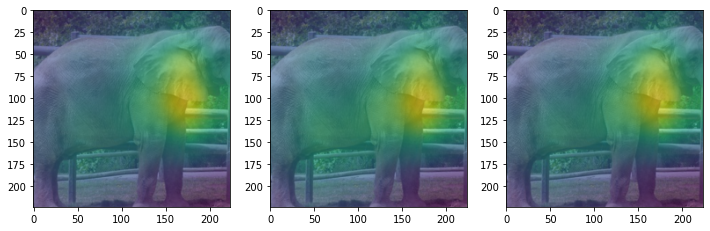



Image  1
Top 3-classes: [334 377 297] ['porcupine, hedgehog', 'marmoset', 'sloth bear, Melursus ursinus, Ursus ursinus']


<Figure size 432x288 with 0 Axes>

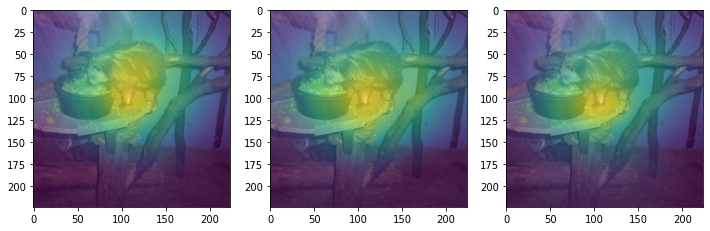



Image  2
Top 3-classes: [200 229 155] ['Tibetan terrier, chrysanthemum dog', 'Old English sheepdog, bobtail', 'Shih-Tzu']


<Figure size 432x288 with 0 Axes>

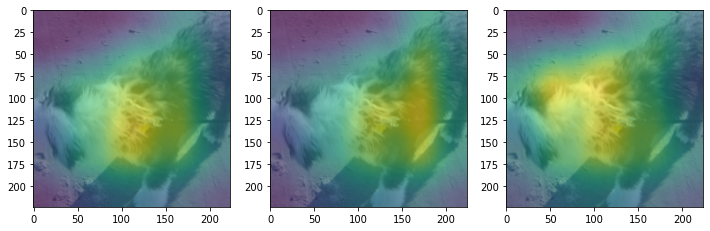



Image  3
Top 3-classes: [174 264 235] ['Norwegian elkhound, elkhound', 'Cardigan, Cardigan Welsh corgi', 'German shepherd, German shepherd dog, German police dog, alsatian']


<Figure size 432x288 with 0 Axes>

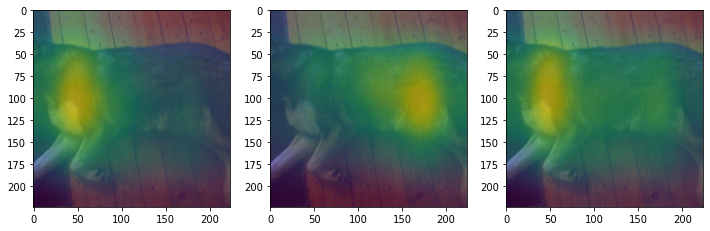



Image  4
Top 3-classes: [217 218 220] ['English springer, English springer spaniel', 'Welsh springer spaniel', 'Sussex spaniel']


<Figure size 432x288 with 0 Axes>

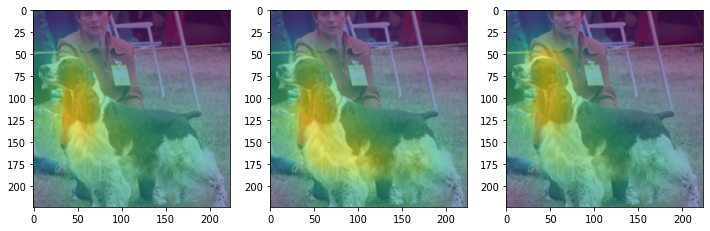



Image  5
Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']


<Figure size 432x288 with 0 Axes>

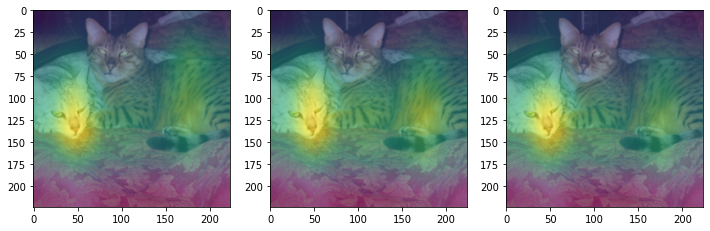



Image  6
Top 3-classes: [279 278 280] ['Arctic fox, white fox, Alopex lagopus', 'kit fox, Vulpes macrotis', 'grey fox, gray fox, Urocyon cinereoargenteus']


<Figure size 432x288 with 0 Axes>

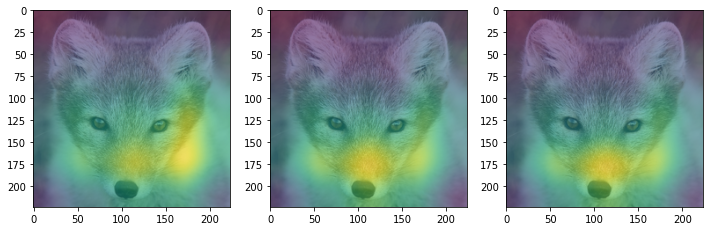



Image  7
Top 3-classes: [246 208 209] ['Great Dane', 'Labrador retriever', 'Chesapeake Bay retriever']


<Figure size 432x288 with 0 Axes>

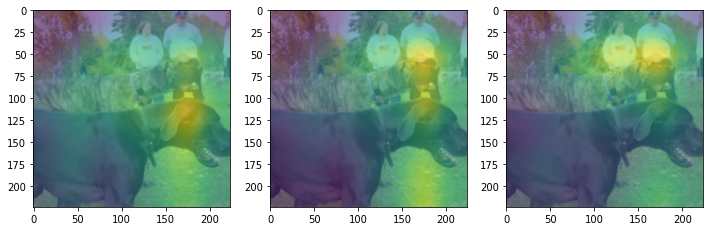



Image  8
Top 3-classes: [356 357 360] ['weasel', 'mink', 'otter']


<Figure size 432x288 with 0 Axes>

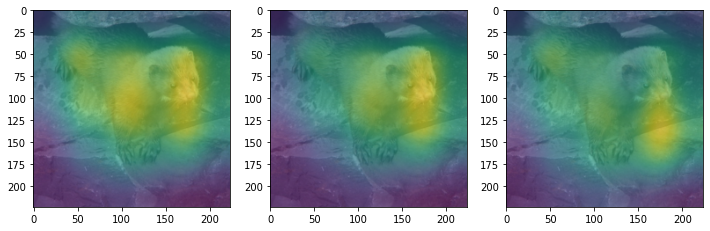



Image  9
Top 3-classes: [350 349 348] ['ibex, Capra ibex', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'ram, tup']


<Figure size 432x288 with 0 Axes>

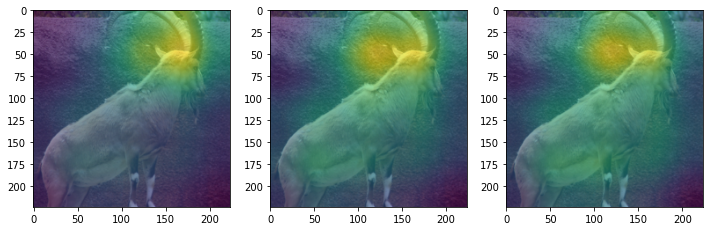



Image  10
Top 3-classes: [339 345 253] ['sorrel', 'ox', 'basenji']


<Figure size 432x288 with 0 Axes>

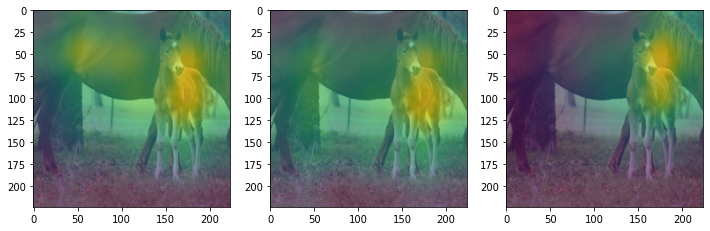



Image  11
Top 3-classes: [271 278 277] ['red wolf, maned wolf, Canis rufus, Canis niger', 'kit fox, Vulpes macrotis', 'red fox, Vulpes vulpes']


<Figure size 432x288 with 0 Axes>

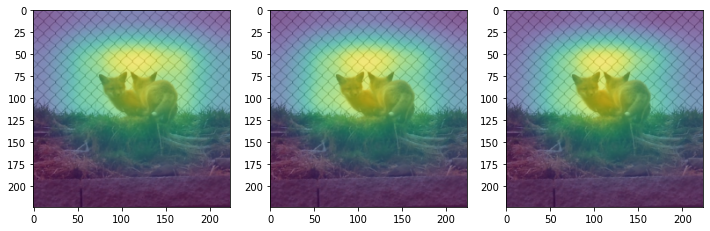



Image  12
Top 3-classes: [136 357  71] ['European gallinule, Porphyrio porphyrio', 'mink', 'scorpion']


<Figure size 432x288 with 0 Axes>

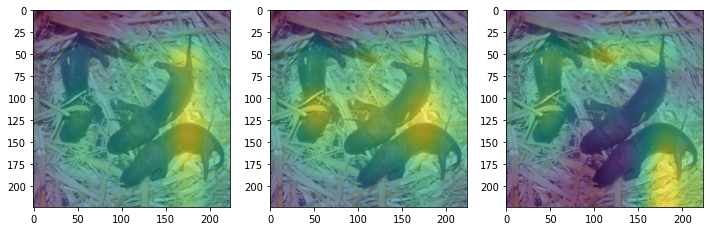



Image  13
Top 3-classes: [352 353 104] ['impala, Aepyceros melampus', 'gazelle', 'wallaby, brush kangaroo']


<Figure size 432x288 with 0 Axes>

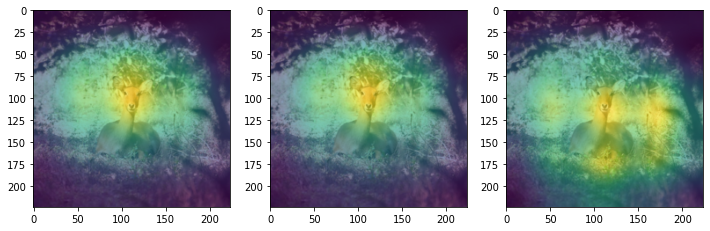



Image  14
Top 3-classes: [286 291 287] ['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'lynx, catamount']


<Figure size 432x288 with 0 Axes>

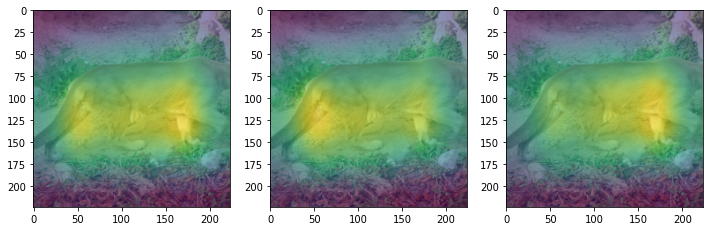



Image  15
Top 3-classes: [150 514 416] ['sea lion', 'cowboy boot', 'balance beam, beam']


<Figure size 432x288 with 0 Axes>

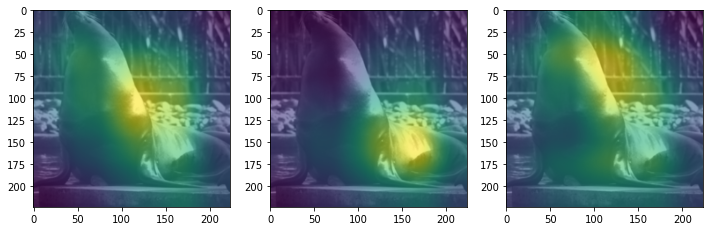



Image  16
Top 3-classes: [380 379 368] ['titi, titi monkey', 'howler monkey, howler', 'gibbon, Hylobates lar']


<Figure size 432x288 with 0 Axes>

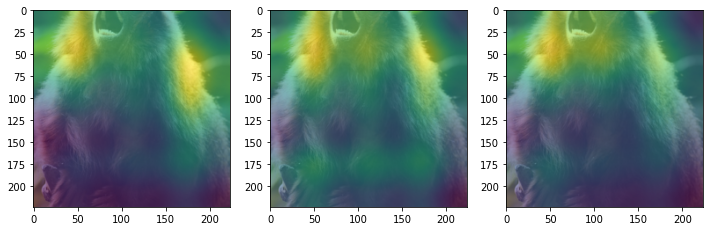



Image  17
Top 3-classes: [387 358 356] ['lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'polecat, fitch, foulmart, foumart, Mustela putorius', 'weasel']


<Figure size 432x288 with 0 Axes>

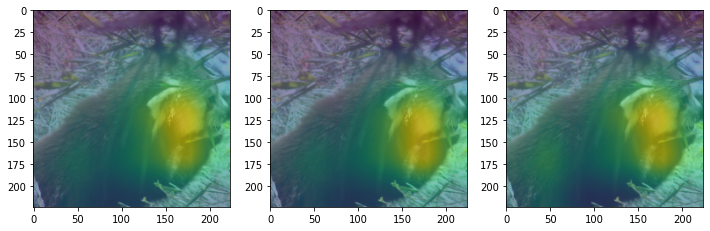



Image  18
Top 3-classes: [377 364 335] ['marmoset', 'three-toed sloth, ai, Bradypus tridactylus', 'fox squirrel, eastern fox squirrel, Sciurus niger']


<Figure size 432x288 with 0 Axes>

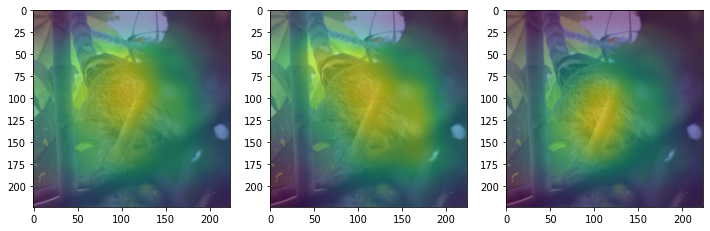



Image  19
Top 3-classes: [382 380 381] ['squirrel monkey, Saimiri sciureus', 'titi, titi monkey', 'spider monkey, Ateles geoffroyi']


<Figure size 432x288 with 0 Axes>

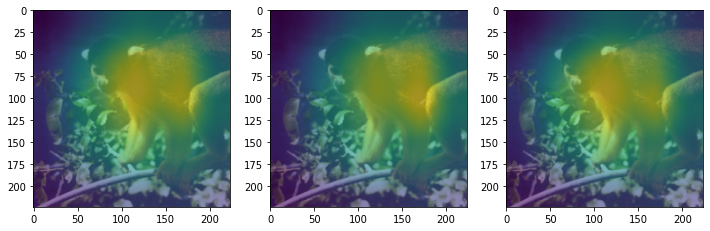

In [ ]:
for i in range(20):
  print("Image ", i)
  plot_top3_cams(i)
  print()


## Comments


Thanks to these visualizations, we can make some interesting findings about the model's performance for some images:

* For image 7 featuring two dogs, the top 3 predicted classes are 'Great Dane', 'Labrador retriever' and 'Chesapeake Bay retriever'. The first prediction is the correct breed of the bottom dog, and in the heatamap we can see that the model focues indeed only on this dog. For the second class, the result is wrong for both dogs and the model focuses on different regions. As for the third class, it is the correct one for the top dog, and the heatmap shows more focus on the area around its head.

* For image 15, the second class with highest score is 'cowboy boots', the heatmap shows the reason behind this mistake; the model focused only on the bottom of the animal.

* For image 10, the first prediction is correct for the big horse which is a 'sorrel' and the model does focus on a part of this animal as well as the small horse. However when the model only focuses on the latter, it mistakenly classifies it as an 'ox' or 'bensji' which are animals of small size compared to horses. The 'basenji' is a dog with similar colors to the small horse: white and brown.
